In [7]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import sympy as sym

In [8]:
# setup of variables
m1,m2,m3,k1,k2,k3,k4,time = sym.symbols('m_1,m_2,m_3,k_1,k_2,k_3,k_4,t') # constants and time
x1 = sym.Function(r'\x_1')(time) # angles
x2 = sym.Function(r'\x_2')(time)
x3 = sym.Function(r'\x_3')(time)
x1d = x1.diff(time) # angular velocites
x2d = x2.diff(time)
x3d = x3.diff(time)
x1dd = x1.diff(time,2) # angular acceleration (we will be solving for these, but it will be useful to have them defined as symbols)
x2dd = x2.diff(time,2)
x3dd = x3.diff(time,2)

# Lagrangian Setup
T = 0.5 * (k1 * x1**2 + k2 * (x1 - x2)**2 + k3 * (x2 - x3)**2 + k4 * x3**2)
V =  0.5 * (m1* x1d **2 + m2 * x2d**2 + m3 * x3d **2)
L = T - V

# Get EOMs from Euler-Lagrange Equation:
left = L.diff(x1)
right = L.diff(x1d).diff(time)
x1dd = sym.solve(sym.Eq(left,right),x1dd)

left1 = L.diff(x2)
right1 = L.diff(x2d).diff(time)
x2dd = sym.solve(sym.Eq(left1,right1),x2dd)

left2 = L.diff(x3)
right2 = L.diff(x3d).diff(time)
x3dd = sym.solve(sym.Eq(left2,right2),x3dd)

print(x1dd,"\n",x2dd,"\n",x3dd)

x1dd_f = sym.lambdify([m1,m2,m3,k1,k2,k3,k4,x1,x2,x3],x1dd,'numpy')
x2dd_f = sym.lambdify([m1,m2,m3,k1,k2,k3,k4,x1,x2,x3],x2dd,'numpy')
x3dd_f = sym.lambdify([m1,m2,m3,k1,k2,k3,k4,x1,x2,x3],x3dd,'numpy')

def derivs(t,curr_vals,m1,m2,m3,k1,k2,k3,k4):

    x1,x1d,x2,x2d,x3,x3d = curr_vals

    return x1d, x1dd_f(m1,m2,m3,k1,k2,k3,k4,x1,x2,x3)[0], x2d, x2dd_f(m1,m2,m3,k1,k2,k3,k4,x1,x2,x3)[0], x3d, x3dd_f(m1,m2,m3,k1,k2,k3,k4,x1,x2,x3)[0]

[(-k_1*\x_1(t) - k_2*\x_1(t) + k_2*\x_2(t))/m_1] 
 [(k_2*\x_1(t) - k_2*\x_2(t) - k_3*\x_2(t) + k_3*\x_3(t))/m_2] 
 [(k_3*\x_2(t) - k_3*\x_3(t) - k_4*\x_3(t))/m_3]


Initial condition in order: $x_1, \dot{x}_1,x_2, \dot{x}_2,x_3, \dot{x}_3$

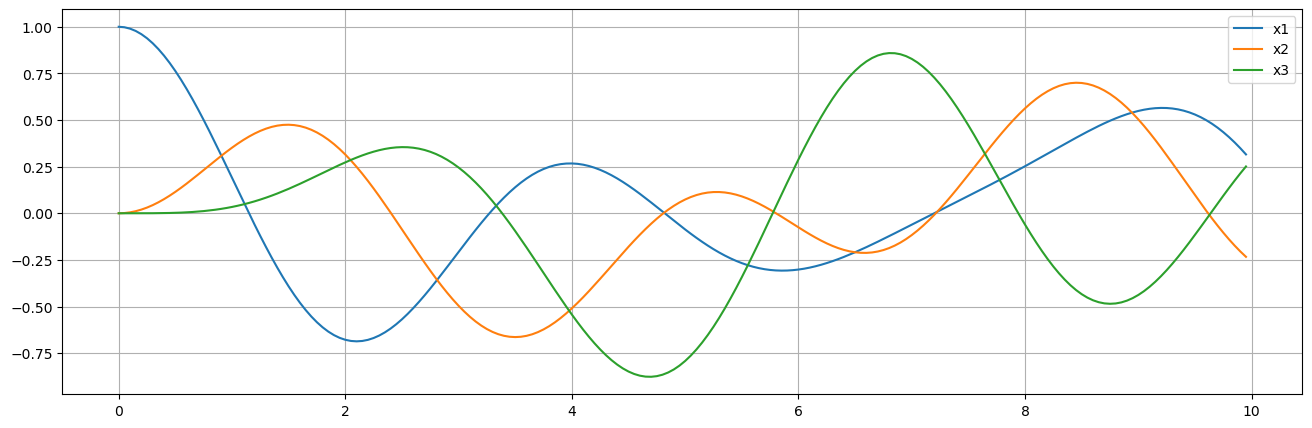

In [9]:
initial = [1,0,0,0,0,0]

tmax = 10
dt = 0.05
t = np.arange(0,tmax,dt)

m1 = 1.
m2 = 1.
m3 = 1.
k1 = 1.
k2 = 1.
k3 = 1.
k4 = 1.
#print(derivs(t,initial,m1,m2,m3,k1,k2,k3,k4))
solved = solve_ivp(derivs,(0,tmax),initial,t_eval = t, args = (m1,m2,m3,k1,k2,k3,k4))

noise_sigma = 0.02
y_true = solved.y #+  noise_sigma* np.random.randn(6,len(t))
x1,x2,x3 = y_true[0], y_true[2], y_true[4]

positions = np.array([solved.y[i] for i in [0,2,4]])

# plt.figure(figsize=(16,5))
# plt.plot(t,solved.y[0],label = 0) # x1
# plt.plot(t,solved.y[2],label = 1) #x2 #x3
# plt.plot(t,solved.y[4],label = 2)
# plt.legend()
# plt.grid()
# plt.show()

plt.figure(figsize = (16,5))
# plt.plot(t,solved.y[1],label = 3)
# plt.plot(t,solved.y[3],label = 4)
# plt.plot(t,solved.y[5],label = 5)
plt.plot(t,x1, label = 'x1')
plt.plot(t,x2, label = "x2")
plt.plot(t,x3, label = "x3")
plt.legend()
plt.grid()
plt.show()

In [5]:
sigma = 0.1
def log_likelihood(theta):
    k1,k2,k3,k4 = theta
    sol = solve_ivp(derivs,(0,tmax),initial,t_eval = t, args = (m1,m2,m3,k1,k2,k3,k4), method = "LSODA")
    return np.sum(np.log(1/(sigma* (2*np.pi)**0.5))-(0.5/sigma**2) * (y_true - sol.y)**2)

D = 4
LB = np.full((1, D), 0.0)  # Lower bounds
UB = np.full((1, D), 100.0)  # Upper bounds


PLB = np.full((1, D), 0.1)
PUB = np.full((1, D), 10.0)

x0 = 4.0 * np.ones((1, D))

prior = SplineTrapezoidal(LB, PLB, PUB, UB)

options = {
    "display": "off"
}

print("LB:",LB,"PLB:",PLB,"PUB:",PUB,"UB:",UB,'x0:',x0) # I hate this
print(LB < PLB)
print(PLB< PUB)
print(PUB < UB)

LB: [[0. 0. 0. 0.]] PLB: [[0.1 0.1 0.1 0.1]] PUB: [[10. 10. 10. 10.]] UB: [[100. 100. 100. 100.]] x0: [[4. 4. 4. 4.]]
[[ True  True  True  True]]
[[ True  True  True  True]]
[[ True  True  True  True]]


In [ ]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior,options = options) # initialize VMBC object

vp, results = vbmc.optimize() # do optimization (might take a while)

: 

: 

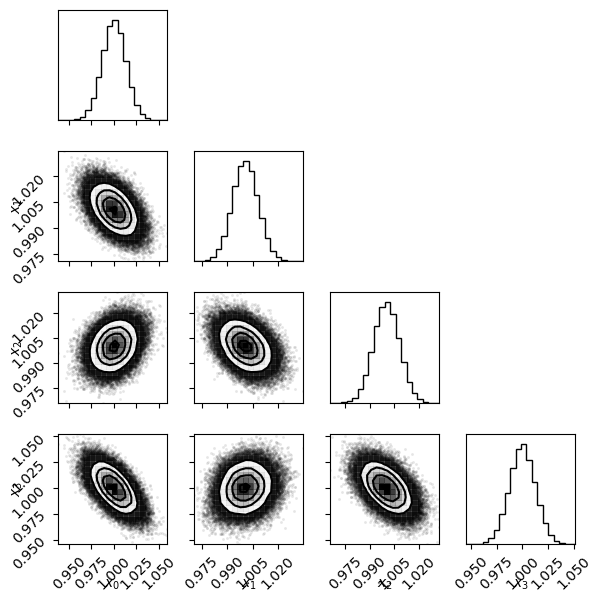

In [30]:
Xs, _ = vp.sample(int(1e6))
vp.plot();

In [217]:
# for i in range(4):
#     plt.figure(figsize = (6,6))
#     plt.hist2d(Xs[:,i-1],Xs[:,i], bins = 100)
#     plt.title(str(i-1) + str(" ")+str(i))
#     plt.xlim(0.95,1.03)
#     plt.ylim(0.95,1.03)
#     plt.axis("equal")
#     plt.show()

In [60]:
def log_likelihood(theta):
    k1,k2,k3,k4,m1,m2,m3 = theta
    sol = solve_ivp(derivs,(0,tmax),initial,t_eval = t, args = (m1,m2,m3,k1,k2,k3,k4), method = "LSODA")
    return np.sum(np.log(1/(sigma* (2*np.pi)**0.5))-(0.5/sigma**2) * (y_true - sol.y)**2)


D = 7
LB = np.full((1, D), 0)  # Lower bounds
UB = np.full((1, D), 50.0)  # Upper bounds


PLB = np.full((1, D), 0.1)
PUB = np.full((1, D), 10.0)

x0 = 1.5 * np.ones((1, D))

prior = SplineTrapezoidal(LB, PLB, PUB, UB)

options = {
    "max_fun_evals": 1000
}

print("LB:",LB,"PLB:",PLB,"PUB:",PUB,"UB:",UB,'x0:',x0) # I hate this
print(LB < PLB)
print(PLB< PUB)
print(PUB < UB)

LB: [[0 0 0 0 0 0 0]] PLB: [[0.1 0.1 0.1 0.1 0.1 0.1 0.1]] PUB: [[10. 10. 10. 10. 10. 10. 10.]] UB: [[50. 50. 50. 50. 50. 50. 50.]] x0: [[1.5 1.5 1.5 1.5 1.5 1.5 1.5]]
[[ True  True  True  True  True  True  True]]
[[ True  True  True  True  True  True  True]]
[[ True  True  True  True  True  True  True]]


In [61]:
vbmc2 = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior,options = options) # initialize VMBC object

vp2, results2 = vbmc2.optimize() # do optimization (might take a while)

Casting lower bounds to floating point.
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action


     0         10      -27877.82     30707.72  44008101.54        2        inf     start warm-up
     1         15       20230.90     18045.06    163463.46        2        inf     
     2         20      -13844.49     17330.87     13136.88        2   3.37e+05     
     3         25        3297.64      9185.19    851114.88        2   1.08e+07     
     4         30       14348.07     15242.29     51573.87        2   7.37e+05     
     5         35       11627.28      8864.06     35354.94        2   4.84e+05     
     6         40        5255.43     13157.93     92408.98        2   1.23e+06     
     7         45       14154.29     14392.42     46305.82        2   6.61e+05     
     8         50        9700.66      7298.99     30920.52        2   4.29e+05     
     9         55        7221.12     10922.54    621369.20        2   7.87e+06     
    10         60         997.40      6035.71     17674.56        2   2.64e+05     
    11         65        4392.21      6054.65     18056.56     

c:\Users\walki\.conda\envs\bpe\Lib\site-packages\gpyreg\noise_functions.py:253: RuntimeWarning: overflow encountered in exp
  sn2 = np.exp(2 * hyp[i])


    53        275        5514.56         0.29         7.88       16        110     
    54        280        5515.27         0.05         7.01       15       90.5     
    55        285        5514.84         0.16         4.76       15       61.8     
    56        290        5514.90         0.10         1.52       15       19.6     
    57        295        5514.99         0.07         1.55       15       20.1     
    58        300        5514.89         0.07         1.81       14       23.4     
    59        305        5515.26         0.03         1.79       14       23.8     
    60        310        5515.09         0.03         0.96       15       12.7     
    61        315        5515.24         0.03         0.64       14       8.59     
    62        320        5514.97         0.10         1.74       14       23.1     
    63        325        5515.17         0.03         2.36       13       30.4     
    64        330        5515.05         0.04         0.91       13       11

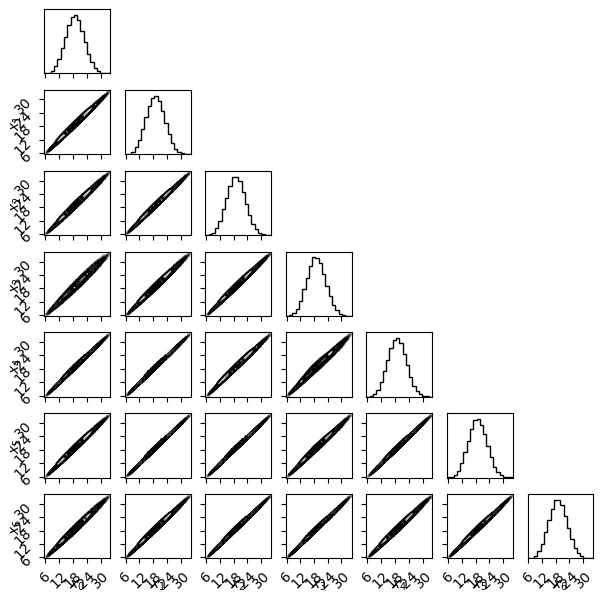

In [62]:
vp2.plot();

200


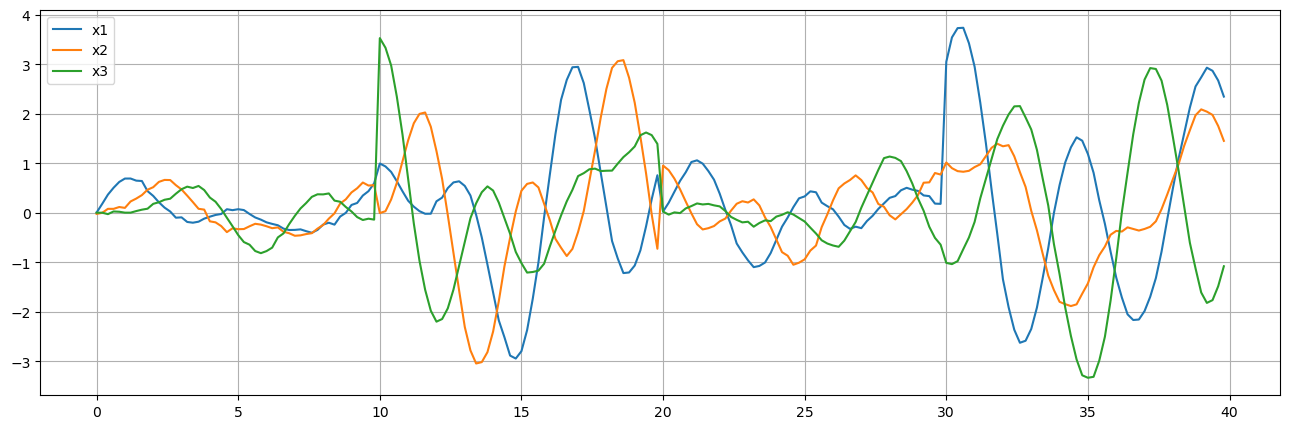

In [10]:
initial1 = [0,1,0,0,0,0]
initial2 = [1,0,0,-0.2,3.5,0]
initial3 = [0,1,1,-0.5,0,-0.2]
initial4 = [3,3,1,-0.5,-1,-0.5]

initial_conditions = [initial1,initial2,initial3,initial4]
noise_sigma = 0.03
sigma = noise_sigma


sols = []
for initial_condition in initial_conditions:
    sol = solve_ivp(derivs,(0,tmax),initial_condition,t_eval = t, args = (m1,m2,m3,k1,k2,k3,k4), method = "LSODA").y + noise_sigma* np.random.randn(6,len(t))
    sols.append(np.array([sol[i] for i in [0,2,4]]))
big_t = np.arange(0,4*tmax,dt )
big_sol = np.concatenate(sols, axis = 1)
y_true = big_sol[:,0::4]

def log_likelihood(theta):
    k1,k2,k3,k4 = theta
    sols = []
    for initial_condition in initial_conditions:
        sol = solve_ivp(derivs,(0,tmax),initial_condition,t_eval = t, args = (m1,m2,m3,k1,k2,k3,k4), method = "LSODA").y
        sols.append(np.array([sol[i] for i in [0,2,4]]))
    big_sol = np.concatenate(sols, axis = 1)
    sliced_sol = big_sol[:,0::4]
    return np.sum(np.log(1/(sigma* (2*np.pi)**0.5))-(0.5/sigma**2) * (y_true - sliced_sol)**2)

plt.figure(figsize = (16,5))
plt.plot(big_t[0::4],y_true[0], label = "x1")
plt.plot(big_t[0::4],y_true[1], label = "x2")
plt.plot(big_t[0::4],y_true[2], label = "x3")
print(len(y_true[0]))
plt.grid()
plt.legend()
plt.show()

In [38]:
D = 4
LB = np.full((1, D), 0.0)  # Lower bounds
UB = np.full((1, D), 50.0)  # Upper bounds


PLB = np.full((1, D), 0.1)
PUB = np.full((1, D), 10.0)

x0 = 1.2 * np.ones((1, D))

prior = SplineTrapezoidal(LB, PLB, PUB, UB)

options = {
    "display": "off",
    "max_fun_evals": 500
}

print("LB:",LB,"PLB:",PLB,"PUB:",PUB,"UB:",UB,'x0:',x0) # I hate this
print(LB < PLB)
print(PLB< PUB)
print(PUB < UB)

LB: [[0. 0. 0. 0.]] PLB: [[0.1 0.1 0.1 0.1]] PUB: [[10. 10. 10. 10.]] UB: [[50. 50. 50. 50.]] x0: [[1.2 1.2 1.2 1.2]]
[[ True  True  True  True]]
[[ True  True  True  True]]
[[ True  True  True  True]]


In [30]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior,options = options) # initialize VMBC object

vp, results = vbmc.optimize() # do optimization (might take a while)

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action


     0         10     -118921.54     77581.02   6503815.34        2        inf     start warm-up
     1         15        4179.90     35397.44     47484.40        2        inf     
     2         20     -151243.24     31170.73      6034.85        2   7.23e+05     
     3         25       -1334.49      3830.99   1077110.11        2   1.85e+07     
     4         30        1440.38       762.52      2592.95        2    5.5e+04     
     5         35         906.34        34.83       714.31        2   1.38e+04     
     6         40         907.65         0.62        13.03        2        224     
     7         45         906.14         0.08         1.14        2       24.3     
     8         50         906.05         0.09         0.32        2       5.79     
     9         55         906.38         0.10         0.11        2       2.63     
    10         60         906.38         0.07         0.01        2      0.337     
    11         65         906.34         0.06         0.04     

c:\Users\walki\.conda\envs\bpe\Lib\site-packages\gpyreg\noise_functions.py:253: RuntimeWarning: overflow encountered in exp
  sn2 = np.exp(2 * hyp[i])


    61        315         905.97         0.07         1.31        5       22.9     
    62        320         905.46         0.07         1.61        5         28     
    63        325         905.67         0.08         2.60        5         44     
    64        330         905.92         0.06         1.36        5       23.3     
    65        335         905.65         0.08         1.67        5       28.6     
    66        340         905.57         0.07         3.01        5       50.5     
    67        345         905.78         0.06         2.69        4       45.4     
    68        350         905.57         0.07         2.54        4         43     
    69        355         906.06         0.06         2.21        4       38.1     
    70        360         905.60         0.06         2.23        5       38.4     
    71        365         905.56         0.10         3.68        5       61.6     
    72        370         905.99         0.05         2.30        5       39

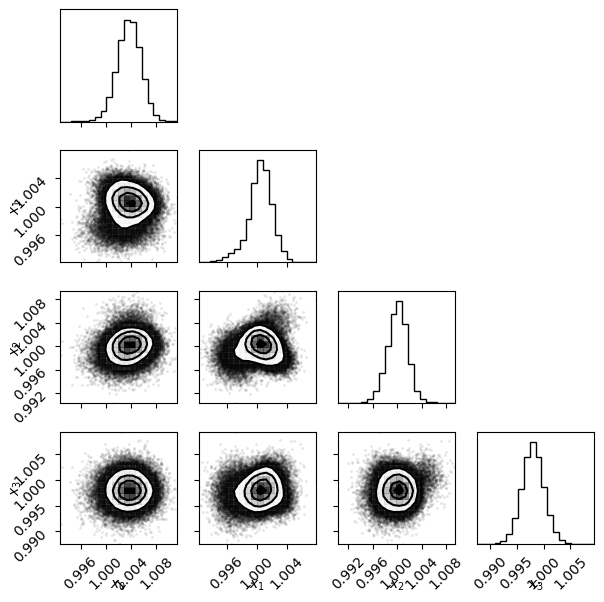

In [32]:
vp.plot();

In [3]:
seeds = np.arange(20)
vbmc_count = 0
for nut in seeds:  
    #     for initial_condition in initial_conditions:
    # sol = solve_ivp(derivs,(0,tmax),initial_condition,t_eval = t, args = (m1,m2,m3,k1,k2,k3,k4), method = "LSODA").y
    # sols.append(np.array([sol[i] for i in [0,2,4]]))
    # big_t = np.arange(0,4*tmax,dt )
    # big_sol = np.concatenate(sols, axis = 1)
    # y_true = big_sol[:,0::4]

    np.random.seed(nut)
    x0 = np.random.uniform(PLB,PUB)

    # # run vbmc and save results
    np.random.seed(nut) 
    vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options)
    np.random.seed(nut) # and this
    vp, results = vbmc.optimize();
    vbmc.vp.save("vp" + str(nut) +  ".pkl", overwrite=True)
    vbmc_count += 1

# save parameter values
#np.savetxt("param_values.csv", np.array(param_list))

In [14]:
for i in range(1,4):
    print(i)

1
2
3


In [18]:
from pyvbmc.acquisition_functions import AcqFcnLog, AcqFcnNoisy, AcqFcnVIQR, AcqFcnIMIQR, AcqFcnVanilla

options = {
    "display": "off",
    "max_fun_evals": 500,
    "search_acq_fcn": []
}

seeds = np.arange(20)
vbmc_count = 0
acquisition_functions = [AcqFcnLog(), AcqFcnNoisy(), AcqFcnVIQR(), AcqFcnIMIQR(), AcqFcnVanilla()]
for acq in acquisition_functions:
    options["search_acq_fcn"] = [acq]
    print(options)

{'display': 'off', 'max_fun_evals': 500, 'search_acq_fcn': [<pyvbmc.acquisition_functions.acq_fcn_log.AcqFcnLog object at 0x000001FDEF488890>]}
{'display': 'off', 'max_fun_evals': 500, 'search_acq_fcn': [<pyvbmc.acquisition_functions.acq_fcn_noisy.AcqFcnNoisy object at 0x000001FDEF49DB10>]}
{'display': 'off', 'max_fun_evals': 500, 'search_acq_fcn': [<pyvbmc.acquisition_functions.acq_fcn_viqr.AcqFcnVIQR object at 0x000001FDEF533E10>]}
{'display': 'off', 'max_fun_evals': 500, 'search_acq_fcn': [<pyvbmc.acquisition_functions.acq_fcn_imiqr.AcqFcnIMIQR object at 0x000001FDEC1184D0>]}
{'display': 'off', 'max_fun_evals': 500, 'search_acq_fcn': [<pyvbmc.acquisition_functions.acq_fcn_vanilla.AcqFcnVanilla object at 0x000001FDEF53FFD0>]}


In [4]:
from pyvbmc import VariationalPosterior

vps = []
for nut in seeds:
    vps.append(VariationalPosterior.load("vp" + str(nut) +  ".pkl"))

moments = []
for vp in vps:
    moments.append(vp.moments())

In [5]:
print(np.asarray(moments)[:,0])

[[ 1.00149668  1.00071495  0.99953986  0.99773012]
 [ 1.3410674  46.05637324  0.87835238  0.53382256]
 [ 1.00150366  1.00072071  0.99946438  0.99776988]
 [ 1.00160308  1.00064528  0.9995208   0.99765288]
 [ 1.00217244  1.00074104  0.99948854  0.99758952]
 [ 1.00152657  1.00069684  0.99951932  0.99762105]
 [ 1.21356955  4.87891202  0.87005094  0.7043865 ]
 [ 1.00011712  1.00110439  0.99983485  0.99859272]
 [ 0.33550471  1.09025842 13.30026469  1.87132779]
 [ 0.5832048   3.18437033  6.3600581   1.29565255]
 [ 1.00241458  1.00028035  0.99925856  0.99777341]
 [ 1.00172375  1.00070424  0.9994585   0.99767998]
 [ 1.21694361  4.93357506  0.90950204  0.6230249 ]
 [ 1.19769538 13.18634623  0.90720286  0.57589686]
 [ 1.0014706   1.00071318  0.9995214   0.99773691]
 [ 4.84407836 34.90579134 17.45051358  8.38619788]
 [ 1.00164774  1.00063998  0.99955558  0.99756755]
 [ 1.13496553  2.69818246  1.26816013  0.47790105]
 [ 1.57487233  0.81146703  0.9879311   0.47691698]
 [ 1.00174745  1.00065378  0.99

[1.00149668 1.00071495 0.99953986 0.99773012]
[ 1.3410674  46.05637324  0.87835238  0.53382256]
[1.00150366 1.00072071 0.99946438 0.99776988]
[1.00160308 1.00064528 0.9995208  0.99765288]
[1.00217244 1.00074104 0.99948854 0.99758952]
[1.00152657 1.00069684 0.99951932 0.99762105]
[1.21356955 4.87891202 0.87005094 0.7043865 ]
[1.00011712 1.00110439 0.99983485 0.99859272]
[ 0.33550471  1.09025842 13.30026469  1.87132779]
[0.5832048  3.18437033 6.3600581  1.29565255]
[1.00241458 1.00028035 0.99925856 0.99777341]
[1.00172375 1.00070424 0.9994585  0.99767998]
[1.21694361 4.93357506 0.90950204 0.6230249 ]
[ 1.19769538 13.18634623  0.90720286  0.57589686]
[1.0014706  1.00071318 0.9995214  0.99773691]
[ 4.84407836 34.90579134 17.45051358  8.38619788]
[1.00164774 1.00063998 0.99955558 0.99756755]
[1.13496553 2.69818246 1.26816013 0.47790105]
[1.57487233 0.81146703 0.9879311  0.47691698]
[1.00174745 1.00065378 0.99950343 0.9975202 ]


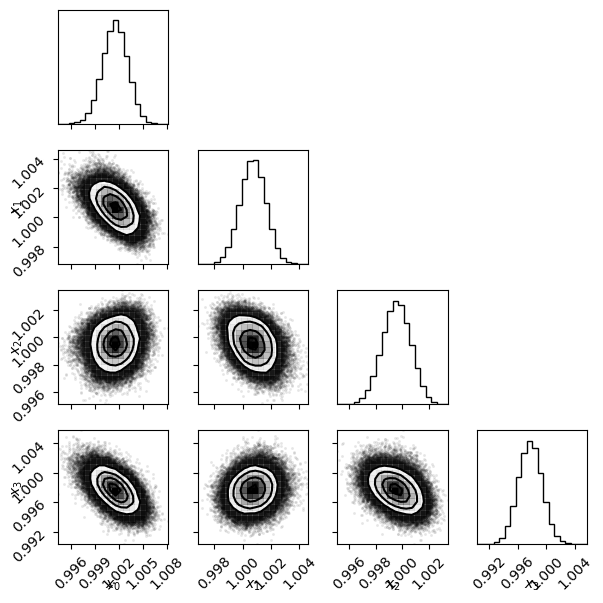

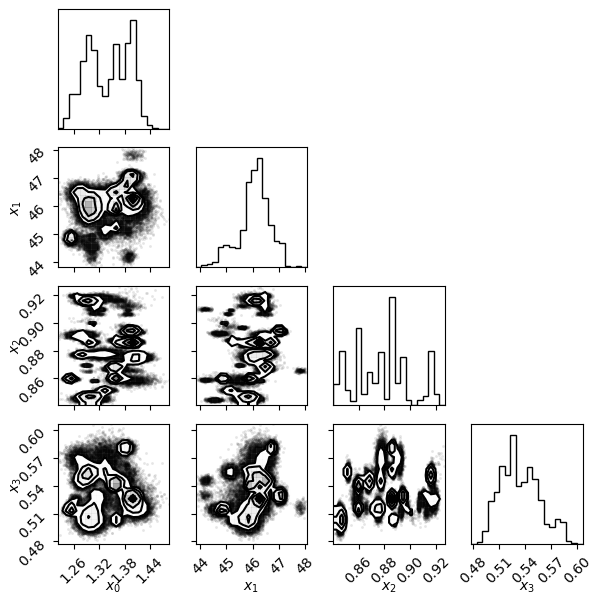

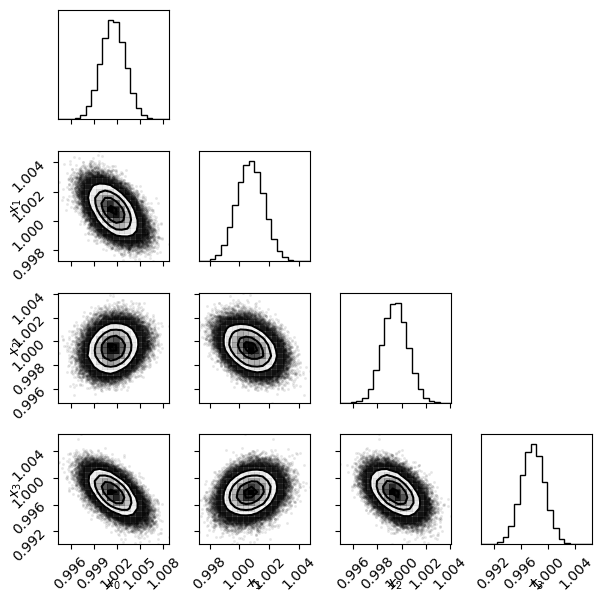

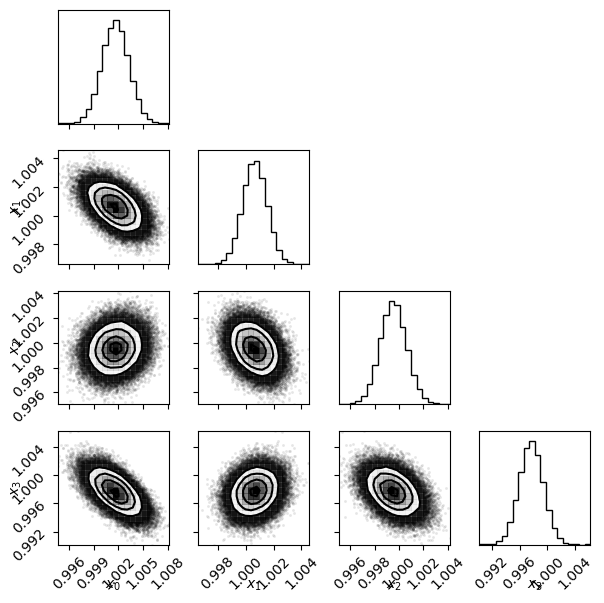

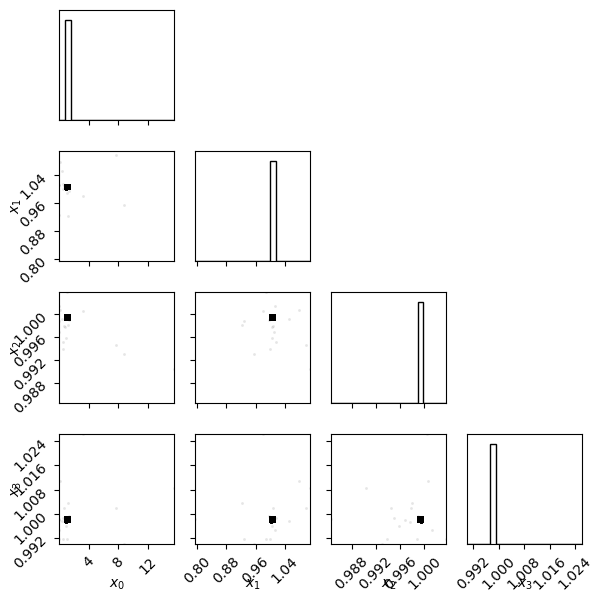

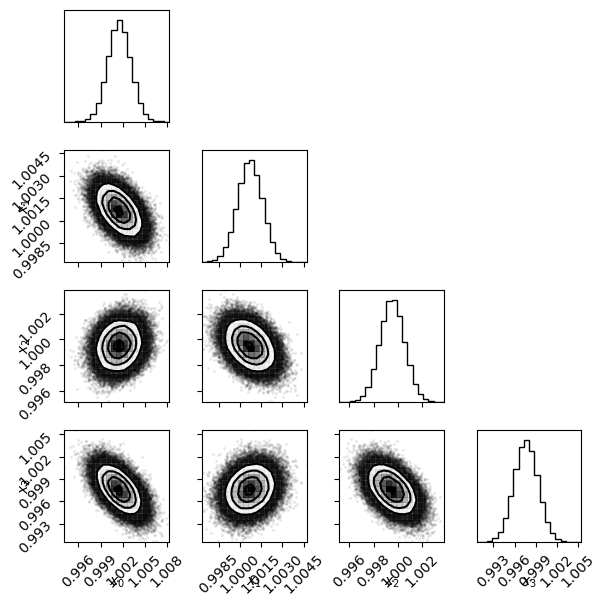

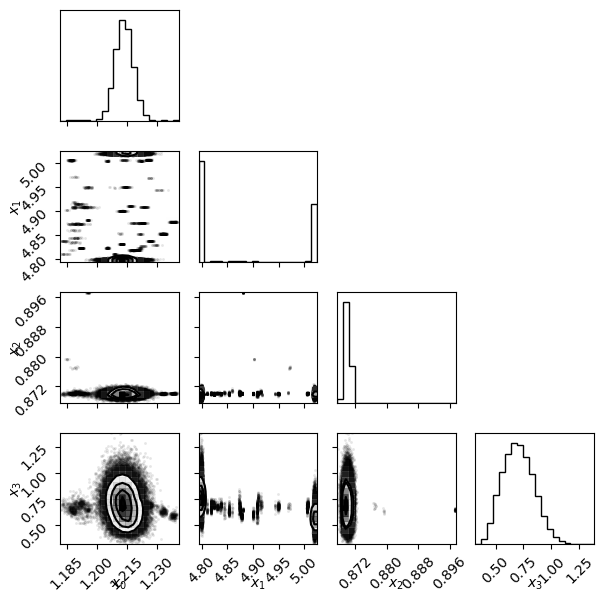

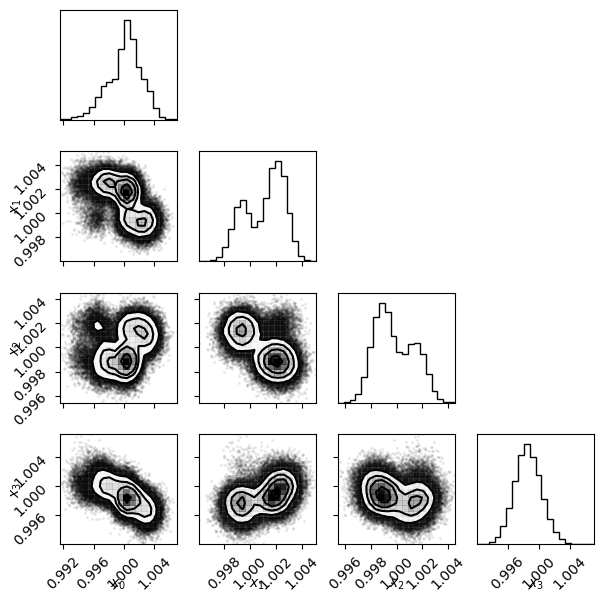

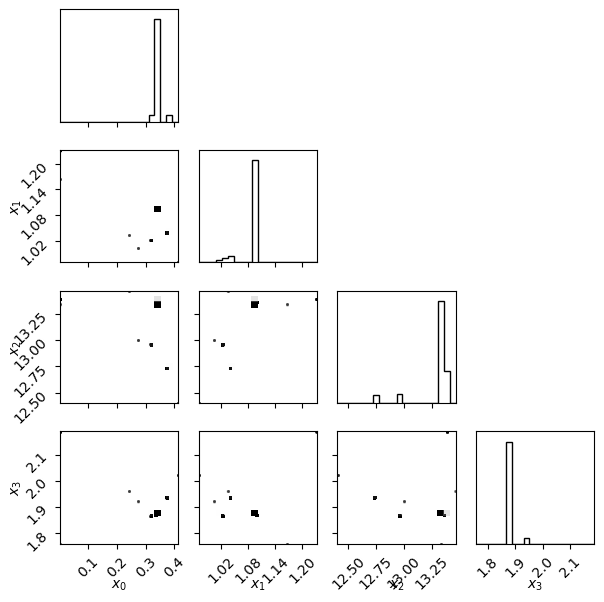

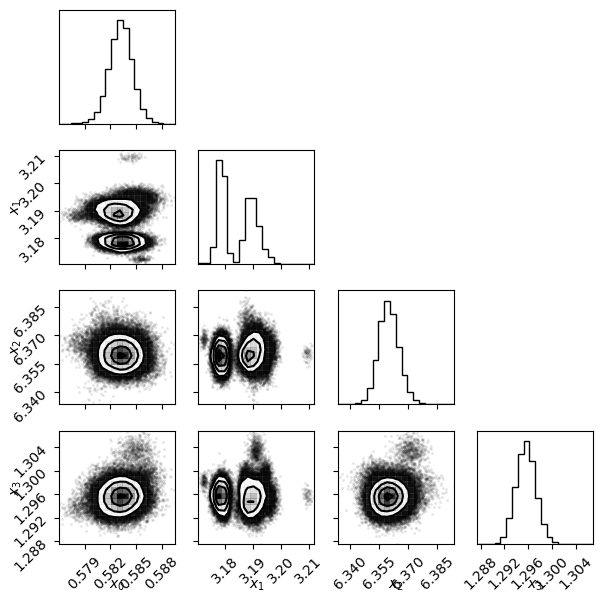

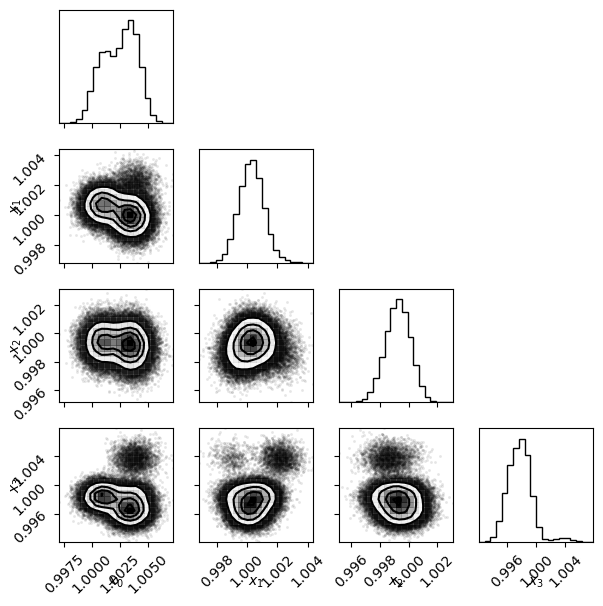

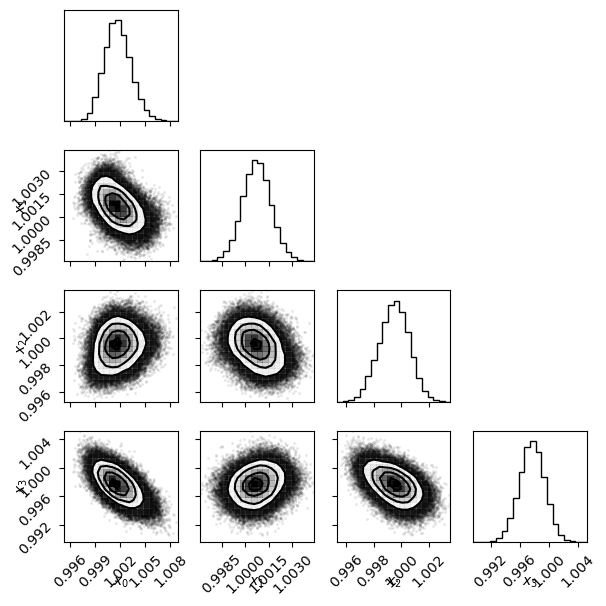

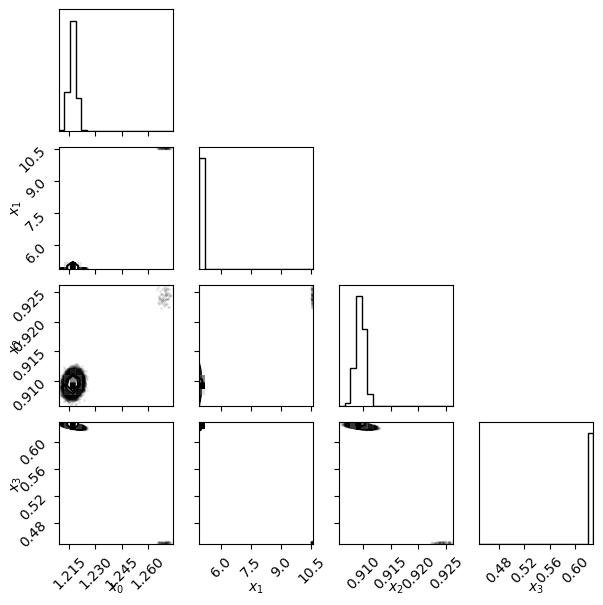

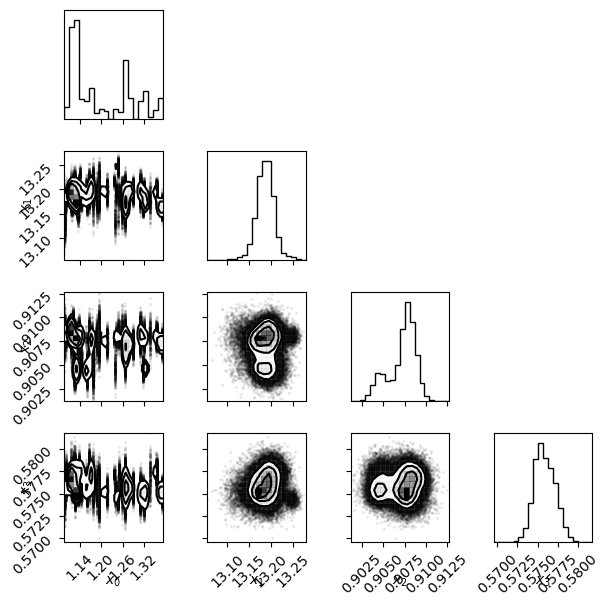

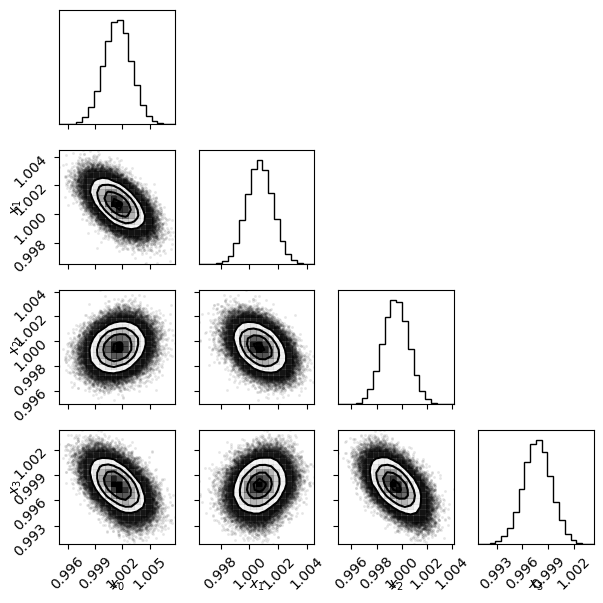

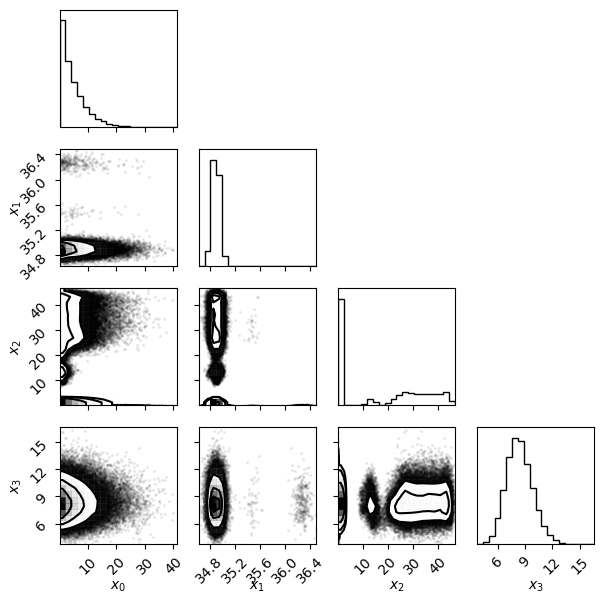

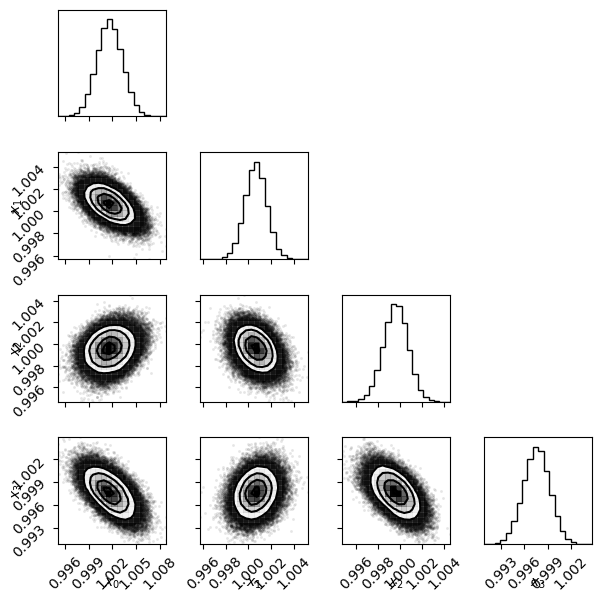

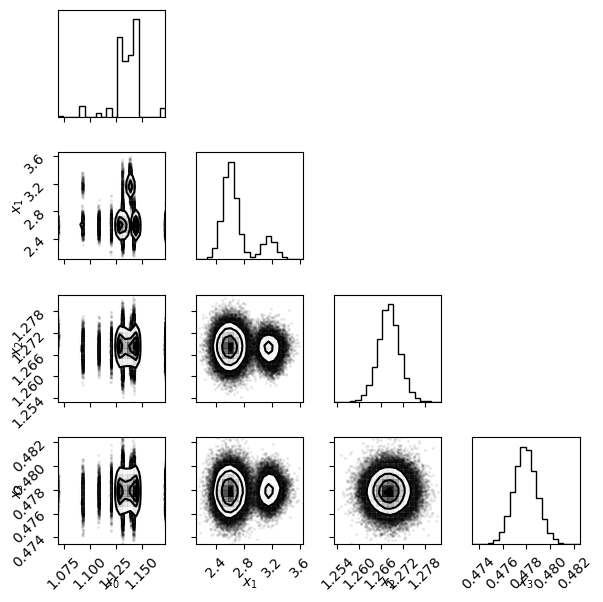

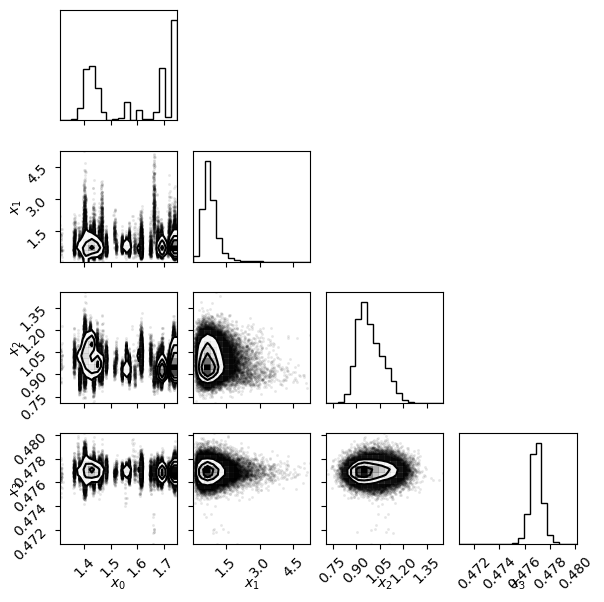

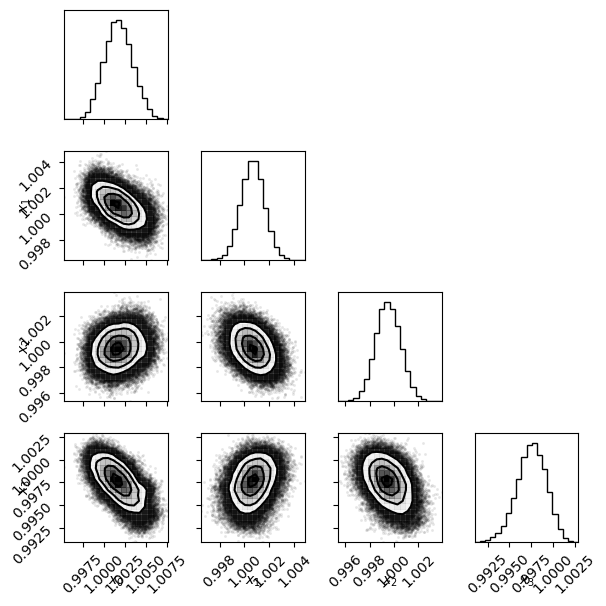

In [6]:
for i,vp in enumerate(vps):
    print(moments[i][0])
    vp.plot();
    